Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/16 02:02:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/16 02:02:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Download Data

In [1]:
from urllib.request import urlretrieve

URL_TEMPLATE = "https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_"
YEAR = '2022'
MONTHS = range(2, 5)
output_relative_dir = '../data/raw/fhvhv_TEST'

for month in MONTHS:
    month = str(month).zfill(2) 
    print(f"Begin month {month}")
    
    # generate url
    url = f'{URL_TEMPLATE}{YEAR}-{month}.parquet'
    # generate output location and filename
    output_dir = f"{output_relative_dir}/{YEAR}-{month}.parquet"
    # download
    urlretrieve(url, output_dir) 
    
    print(f"Completed month {month}")

Begin month 02
Completed month 02
Begin month 03
Completed month 03
Begin month 04
Completed month 04


In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Ass1 ESA")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/20 21:51:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sdf = spark.read.parquet('../data/raw/fhvhv')


In [4]:
from pyspark.sql import functions as F
from scipy.stats import ttest_ind
sdf = sdf.withColumn("price_per_dist", sdf.base_passenger_fare/sdf.trip_time)
sdf = sdf.withColumn("isAirportTrip", sdf.airport_fee > 0)
sdf = sdf.filter((F.col("price_per_dist") > 0) & (F.col("price_per_dist") < .5))

sdf.filter(F.col("airport_fee") > 0).filter((F.col("price_per_dist") > 0)).select("price_per_dist").summary()
sdf.limit(10)


/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


22/08/17 22:05:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22/08/17 22:05:42 ERROR Executor: Exception in task 5.0 in stage 4.0 (TID 21)
java.lang.OutOfMemoryError: Java heap space
	at java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:57)
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:335)
	at org.apache.parquet.bytes.HeapByteBufferAllocator.allocate(HeapByteBufferAllocator.java:32)
	at org.apache.parquet.hadoop.ParquetFileReader$ConsecutivePartList.readAll(ParquetFileReader.java:1696)
	at org.apache.parquet.hadoop.ParquetFileReader.readNextRowGroup(ParquetFileReader.java:925)
	at org.apache.parquet.hadoop.ParquetFileReader.readNextFilteredRowGroup(ParquetFileReader.java:972)
	at org.apache.spark.sql.execution.datasources.parquet.SpecificParquetRecordReaderBase$ParquetRowGroupReaderImpl.readNextRowGroup(SpecificParquetRecordReaderBase.java:266)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.checkEndOfRowGroup(VectorizedParquetRecordReader.java:388)
	at org.apache.spark.sql.execution.datasources.parquet.

22/08/17 22:05:43 ERROR Executor: Exception in task 9.0 in stage 4.0 (TID 25)
java.lang.OutOfMemoryError: Java heap space
22/08/17 22:05:43 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[Executor task launch worker for task 9.0 in stage 4.0 (TID 25),5,main]
java.lang.OutOfMemoryError: Java heap space


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/IPython/core/formatters.py", line 222, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/IPython/core/formatters.py", line 707, in __call__
    printer.pretty(obj)
  File "/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/IPython/lib/pretty.py", line 410, in pretty
    return _repr_pprint(obj, self, cycle)
  File "/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/IPython/lib/pretty.py", line 778, in _repr_pprint
    output = repr(obj)
  File "/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/pyspark/sql/dataframe.py", line 620, in __repr__
    return self._jdf.showString(
  File "/home/saurabhjhanjee/an

ConnectionRefusedError: [Errno 111] Connection refused

In [5]:
sdf.filter(F.col("airport_fee") == 0).select("price_per_dist").filter((F.col("price_per_dist") > 0)).summary()


summary,price_per_dist
count,28881818
mean,0.021942136160303535
stddev,0.009817421488282402
min,2.102165230187093E-6
25%,0.01633776091081594
50%,0.019609800362976406
75%,0.024565217391304347
max,0.4981944444444444


In [6]:
df = sdf.sample(0.001, seed=0).toPandas() 

22/08/17 22:01:57 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22/08/17 22:01:58 ERROR Executor: Exception in task 5.0 in stage 7.0 (TID 36)
java.lang.OutOfMemoryError: Java heap space
	at java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:57)
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:335)
	at org.apache.parquet.bytes.HeapByteBufferAllocator.allocate(HeapByteBufferAllocator.java:32)
	at org.apache.parquet.hadoop.ParquetFileReader$ConsecutivePartList.readAll(ParquetFileReader.java:1696)
	at org.apache.parquet.hadoop.ParquetFileReader.readNextRowGroup(ParquetFileReader.java:925)
	at org.apache.parquet.hadoop.ParquetFileReader.readNextFilteredRowGroup(ParquetFileReader.java:972)
	at org.apache.spark.sql.execution.datasources.parquet.SpecificParquetRecordReaderBase$ParquetRowGroupReaderImpl.readNextRowGroup(SpecificParquetRecordReaderBase.java:266)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.checkEndOfRowGroup(VectorizedParquetRecordReader.java:388)
	at org.apache.spark.sql.execution.datasources.parquet.

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/saurabhjhanjee/anaconda3/envs/applied-data-science1/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/saurabhjhanjee/anaconda3/

ConnectionRefusedError: [Errno 111] Connection refused

In [40]:
ttest_ind(df.loc[df["isAirportTrip"]]["price_per_dist"], df.loc[df["isAirportTrip"] == False]["price_per_dist"], equal_var=False, alternative="greater")


Ttest_indResult(statistic=51.713138597949616, pvalue=0.0)

hvfhs_license_num       696994
dispatching_base_num    696994
originating_base_num    513631
request_datetime        696994
on_scene_datetime       513693
pickup_datetime         696994
dropoff_datetime        696994
PULocationID            696994
DOLocationID            696994
trip_miles              696994
trip_time               696994
base_passenger_fare     696994
tolls                   696994
bcf                     696994
sales_tax               696994
congestion_surcharge    696994
airport_fee             696994
tips                    696994
driver_pay              696994
shared_request_flag     696994
shared_match_flag       696994
access_a_ride_flag      696994
wav_request_flag        696994
wav_match_flag          696994
price_per_dist          696994
isAirportTrip           696994
dtype: int64

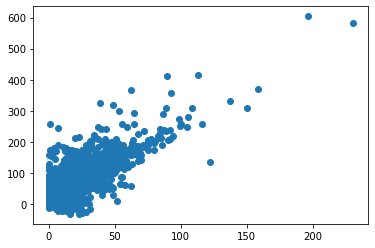

In [27]:
from matplotlib import pyplot as plt

plt.scatter(df["trip_miles"], df["base_passenger_fare"])
plt.show()

(array([6.40000e+02, 1.15382e+05, 2.76000e+03, 2.05000e+02, 3.50000e+01,
        1.00000e+01, 3.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-0.02114754,  0.0075293 ,  0.03620615,  0.064883  ,  0.09355984,
         0.12223669,  0.15091353,  0.17959038,  0.20826722,  0.23694407,
         0.26562092]),
 <BarContainer object of 10 artists>)

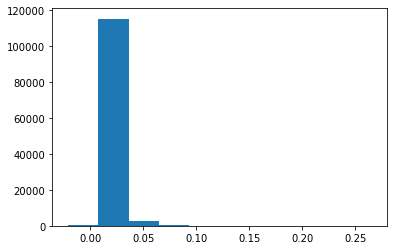

In [40]:
plt.hist(df[abs(df["price_per_dist"]) < 0.3]["price_per_dist"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3fde08fbb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3fda18c2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3fde08f8e0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f3fda18c8b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3fda18c850>,
 'means': []}

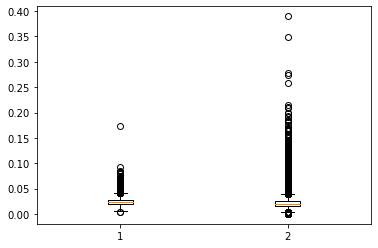

In [36]:
plt.boxplot((df.loc[df["isAirportTrip"]]["price_per_dist"], df.loc[df["isAirportTrip"] == False]["price_per_dist"]))

In [45]:
df[abs(df["price_per_dist"]) > 0.2].loc[:, ~df.columns.isin(['originating_base_num', 'dispatching_base_num', 'on_scene_datetime', 'access_a_ride_flag', ...])].sort_values(by="price_per_dist", ascending=False)

,hvfhs_license_num,request_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,wav_request_flag,wav_match_flag,price_per_dist
69998,HV0004,2021-01-20 08:21:13,2021-01-20 08:23:45,2021-01-20 08:23:49,48,107,0.000,3,25.71,0.0,...,1.83,2.75,NaN,0.0,0.00,N,N,N,N,8.570000
52348,HV0003,2021-01-15 14:10:35,2021-01-15 14:16:14,2021-01-15 14:16:20,17,17,0.010,6,6.37,0.0,...,0.57,0.00,NaN,0.0,5.43,N,N,N,N,1.061667
293,HV0005,2021-01-01 00:10:24,2021-01-01 00:12:04,2021-01-01 00:12:17,262,262,0.017,13,10.85,0.0,...,0.96,2.75,NaN,0.0,5.47,N,N,N,N,0.834615
43098,HV0003,2021-01-13 02:50:47,2021-01-13 02:51:16,2021-01-13 02:51:29,197,134,0.030,13,5.75,0.0,...,0.51,0.00,NaN,0.0,5.39,N,N,N,N,0.442308
90588,HV0003,2021-01-25 06:10:29,2021-01-25 06:18:02,2021-01-25 06:26:21,247,69,1.210,499,159.99,0.0,...,0.89,0.00,NaN,0.0,6.07,N,N,N,N,0.320621
50394,HV0003,2021-01-15 00:49:33,2021-01-15 00:56:02,2021-01-15 01:06:14,160,197,2.520,612,162.56,0.0,...,1.11,0.00,NaN,0.0,7.90,N,N,N,N,0.265621
67464,HV0005,2021-01-19 13:37:51,2021-01-19 13:39:27,2021-01-19 13:39:56,263,263,0.127,29,7.30,0.0,...,0.65,2.75,NaN,0.0,5.47,N,N,N,N,0.251724
95473,HV0003,2021-01-26 13:42:56,2021-01-26 13:46:24,2021-01-26 13:52:13,89,188,0.680,349,70.70,0.0,...,0.51,0.00,NaN,0.0,5.40,N,N,N,N,0.202579
